In [49]:
import networkx as nx

# My code
import fast_gillespie as fg
import fast_gillespie_viz2 as fgv
import networkx as nx
import matplotlib.pyplot as plt

mean_num_monomers =  100.0
interactions_param =  30.0


Progress:   0%|          | 0/30000 [00:00<?, ?it/s]

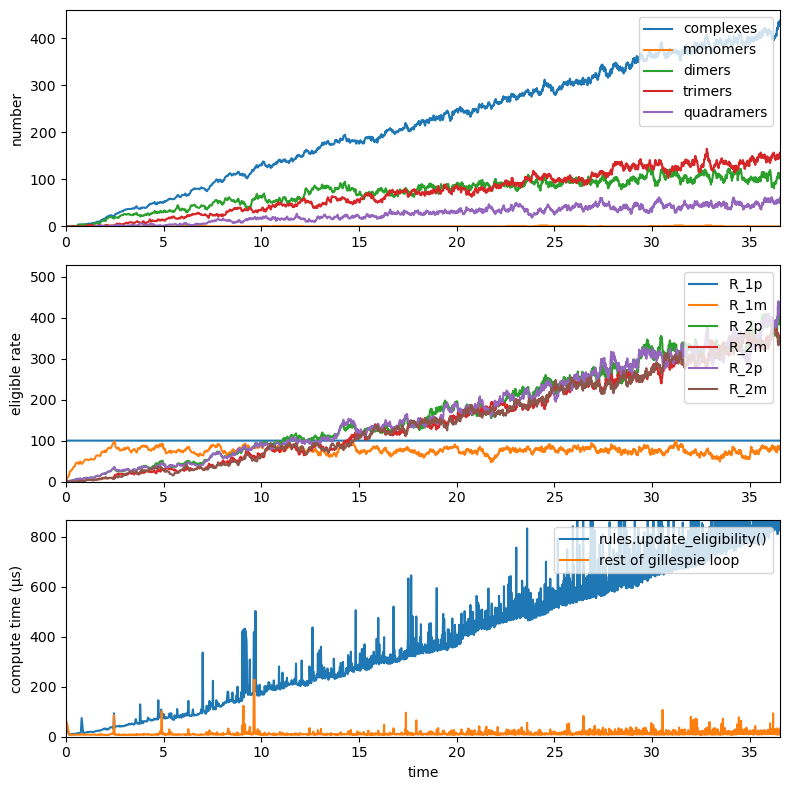

In [60]:
#Define branched homopolymer

# Rates in terms of interpretable quantities
mean_num_monomers = 100.0
interactions_param = 30.0  # I don't have a good interpretation for this
rate2_multiplier = 1
rate1p = mean_num_monomers
rate1m = 1.0
rate2p = rate2_multiplier*interactions_param/(mean_num_monomers**2)
rate2m = rate2_multiplier*1.0

# Print out rate-determining quantities
print('mean_num_monomers = ', mean_num_monomers)
print('interactions_param = ', interactions_param)

# Create fields
A = fg.Field(name='A', index_dim=1)
a = fg.Field(name='a', index_dim=1)
b = fg.Field(name='b', index_dim=1)
c = fg.Field(name='c', index_dim=1)
J = fg.Field(name='J', index_dim=2)

# Create/annihilate A monomer
R_1p = fg.MonomerCreationRule(name='R_1p', rate=rate1p, particle=A, sites=[a,b])
R_1m = fg.MonomerAnnihilationRule(name='R_1m', rate=rate1m, particle=A, sites=[a,b])

# Create/annihilate J_A:a_B:c interaction
R_2p1 = fg.HeterotypicInteractionCreationRule(name='R_2p', rate=rate2p, A=A, B=A, a=a, b=c, J=J)
R_2m1 = fg.HeterotypicInteractionAnnihilationRule(name='R_2m', rate=rate2m, A=A, B=A, a=a, b=c, J=J)       

# Create/annihilate J_A:b_B:c interaction
R_2p2 = fg.HeterotypicInteractionCreationRule(name='R_2p', rate=rate2p, A=A, B=A, a=b, b=c, J=J)
R_2m2 = fg.HeterotypicInteractionAnnihilationRule(name='R_2m', rate=rate2m, A=A, B=A, a=b, b=c, J=J)    

# Define fock space and rules
space = fg.FockSpace(fields=[A, a, b, c, J])
rules = fg.RuleSet(rules=[R_1p, R_1m, R_2p1, R_2m1, R_2p2, R_2m2])

# Define summary stats to record
def summary_stats_func():
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from(J.indices)
    connected_components = list(nx.weakly_connected_components(G))
    component_sizes = [len(c) for c in nx.weakly_connected_components(G)]
    num_components = len(connected_components)
    size_dict = {size: component_sizes.count(size) for size in set(component_sizes)}
    
    stats_dict = dict(
        # particles=len(A.indices),
        # interactions=len(J.indices),
        complexes=num_components,
        monomers=size_dict.get(1,0),
        dimers=size_dict.get(2,0),
        trimers=size_dict.get(3,0),
        quadramers=size_dict.get(4.0)
    )
    return stats_dict

# Define, initialize, and run simulation
sim = fg.Simulation(space=space, rules=rules, custom_stats_func=summary_stats_func)
sim.initialize_state()
sim.run(num_steps=30_000, record_every=10)

fgv.show_sim_stats(sim, x_is_time=True)


[{2633, 2884} {1124, 2885, 710, 2733, 2670, 727, 1177, 2651} {664, 529}
 {954, 1282} {326, 908, 1680, 208, 1494} {604, 351}
 {3584, 3617, 1287, 81, 1750, 119} {235, 221, 1767} {400, 277, 383}
 {2400, 2465, 3522, 3236, 1668, 1861, 2919, 3335, 2826, 1388, 3276, 3184}
 {3492, 2542} {2148, 2418, 1976, 1981, 2271} {48, 132, 2430}
 {2182, 3013, 2254} {2080, 2065, 3491, 3636} {1189, 938, 1546, 2192, 2228}
 {1800, 1341} {1096, 1018, 941, 1119} {2946, 3182} {1922, 1599} {2908}
 {2928, 2002, 2107, 3565} {2113, 1988, 1766, 1753} {3176}
 {1280, 2023, 2641, 1209, 2075} {1032, 2251, 2156, 1677, 816, 1042, 761}
 {3113, 2759} {3615}
 {1920, 2626, 3399, 2568, 2954, 2446, 3540, 3286, 3063, 2936, 2809, 1946, 2646, 2812, 1439}
 {2163, 851, 806, 3306}]


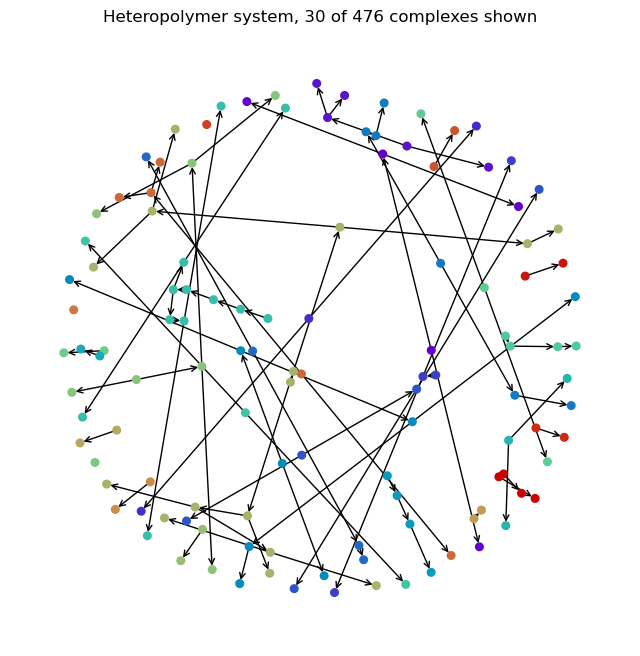

In [61]:
fgv.plot_state(particle=A, interaction=J, directed=True, system_name='Heteropolymer', max_connected_components=30)

Text(0, 0.5, 'number of complexes of given size')

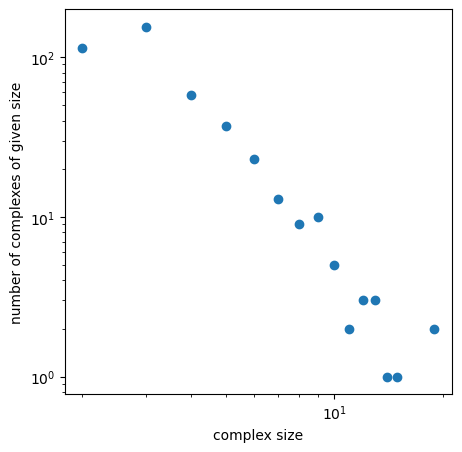

In [62]:
# Plot a histogram of complex sizes. 
G = nx.DiGraph()
G.add_edges_from(J.indices)
connected_components = list(nx.weakly_connected_components(G))
component_sizes = [len(c) for c in nx.weakly_connected_components(G)]
size_dict = {size: component_sizes.count(size) for size in set(component_sizes)}
counts = size_dict.values()
sizes = size_dict.keys()

fig, ax = plt.subplots(figsize=(5,5))
ax.loglog(sizes, counts, marker='o', linestyle='none')
ax.set_xlabel('complex size')
ax.set_ylabel('number of complexes of given size')